# 9. 임베딩 내 편향성 알아보기[프로젝트]
## 9-1. 프로젝트 : 모든 장르 간 편향성 측정해 보기

In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pk

import konlpy
import gensim
import sklearn
import seaborn

from konlpy.tag import Okt
from gensim.models import Word2Vec

### STEP1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [2]:
okt = Okt()
tokenized = []

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)
        
len(tokenized)

71156

In [3]:
with open('weat/tokenized.pkl', 'wb') as f:
    pk.dump(tokenized, f)

### STEP2. 추출된 결과로 embedding model 만들기

In [75]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.8894510865211487),
 ('다큐멘터리', 0.8640532493591309),
 ('에마데딘', 0.8315603733062744),
 ('드라마', 0.8146573901176453),
 ('영화로', 0.8008314967155457),
 ('형식', 0.7795081734657288),
 ('실화', 0.7758312225341797),
 ('코미디', 0.7753998041152954),
 ('주제', 0.764462947845459),
 ('소재', 0.7554070949554443)]

In [80]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.7009510397911072),
 ('시빌라', 0.6950390338897705),
 ('행복', 0.6893033981323242),
 ('만남', 0.6870806813240051),
 ('애정', 0.6848433613777161),
 ('진심', 0.6797758936882019),
 ('운명', 0.6795557737350464),
 ('스트라빈스키', 0.6708754897117615),
 ('우정', 0.6692008972167969),
 ('감정', 0.6688361763954163)]

### STEP3. target, attribute 단어 셋 만들기

이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다.   
이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다.   
그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다.   
개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.  
  
TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다.  
TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

In [5]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [6]:
with open('weat/art_txt.pkl', 'wb') as f:
    pk.dump(art, f)
    
with open('weat/gen_txt.pkl', 'wb') as f:
    pk.dump(gen, f)

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

(2, 41082)
23976
영화
예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [9]:
target_art = [ vectorizer.get_feature_names()[w1[i][0]] for i in range(100) ]
target_gen = [ vectorizer.get_feature_names()[w2[i][0]] for i in range(100) ]

In [10]:
print(len(target_art))
print(len(target_gen))
print(len(set(target_art) & set(target_gen)))

100
100
84


단순히 TF-IDF만 적용하면 중복 단어가 많음

In [81]:
# min_df: 특정 단어가 나타나는 최소 문서 수(또는 비율)
# max_df: 특정 단어가 나타나는 최대 문서 수(또는 비율)
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.9)
X = vectorizer.fit_transform([art, gen])

print(X.shape)

#print(vectorizer.vocabulary_['영화'])
#print(vectorizer.get_feature_names()[23976])

m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

(2, 25452)
예술영화를 대표하는 단어들:
지라니, 불찰, 규민, 볼쇼, 순영, 예준, 아이누, 유영철, 무쉬, 야스쿠니, 나다니엘, 비랄, 석용, 한대수, 토미카, 아화, 병운, 이샨, 디앤, 수욱, 숏버스, 원훈, 하치코, 질베르트, 장닝, 가츠노, 노승, 승업, 구구, 송현, 영건, 나즈나, 밀례나, 가부, 듀란, 딘딘, 정득, 리윈펑, 호찬, 가위눌림, 릿카, 니켈, 비보잉, 홀츠, 안드라스, 도그빌, 거미숲, 이감, 바웬사, 청림, 데레사, 쿰바, 성미산, 현순, 루비살롱, 거칠마루, 종섭, 신웅, 신덴, 장경, 띠마, 써머, 시형, 양산박, 고정원, 파비아, 크리스티아노, 배틀오브더이어, 비투스, 아틸리오, 카포티, 변학범, 돌포, 브리스, 우남, 사일런스, 혁진, 이원상, 까미유, 창국, 채미, 관타나모, 박덕, 아렌다, 황제펭귄, 밍쿠, 브러시, 발드, 송사, 심유, 가후, 호쿠, 노준, 포욱, 급시, 영택, 아키히토, 아르파, 비글, 싱크로나이즈, 

일반영화를 대표하는 단어들:
아시아나, 도롱, 인권영화제, 테드, 타케시, 경력, 퍼니퍼, 메트로, 카즈야, 큐빅스, 페스트, 애무, 미장센단편영화제, 엽기, 영훈, 코드, 빈스, 건축사, 소비, 와이드, 점프, 상제, 곰퉁, 마유미, 스와핑, 사오리, 전복, 추상, 성현, 육감, 삼순, 나츠미, 의붓아들, 아리사, 다이스케, 임팩트, 동현, 숙희, 게리, 강력반, 공중, 나오키, 기철, 마작, 쇼코, 콜롬비아, 스타크, 커피숍, 오오시마, 로보트, 채널, 지환, 미치루, 대호, 토네이도, 후지, 유성, 레미, 숨바꼭질, 투수, 벙커, 미얀마, 체첸, 아영, 과자, 우수상, 마누, 혼령, 파친코, 토마토, 모기, 타키, 음란, 가가, 아유미, 스펜서, 요시다, 종수, 행크, 명주, 정욱, 우석, 양쪽, 대부, 소스, 팬티, 블레이드, 퇴원, 진헌, 케코, 태호, 쿠로다, 리플리, 태주, 쟈니, 성호, 헤더, 커크, 폭주족, 마구, 

In [82]:
target_art = [ vectorizer.get_feature_names()[w1[i][0]] for i in range(100) ]
target_gen = [ vectorizer.get_feature_names()[w2[i][0]] for i in range(100) ]

print(len(target_art))
print(len(target_gen))
print("중복 단어 수 : ", len(set(target_art) & set(target_gen)))

100
100
중복 단어 수 :  0


vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.9) 옵션을 통해  
target_art, target_gen 간의 중복값을 모두 없앰

In [83]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

In [84]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [85]:
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.9)
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 31949)


In [86]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
attributes = []

for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 여자, 단편, 연출, 여행, 할머니, 아빠, 상처, 문제, 배우, 부부, 노인, 회사, 촬영, 동네, 오늘, 
멜로로맨스: 여자, 섹스, 부부, 회사, 연애, 여행, 커플, 정사, 유부녀, 새엄마, 고백, 여자친구, 불륜, 이혼, 출장, 
액션: 범죄, 보스, 수사, 인류, 여자, 킬러, 암살, 감옥, 게임, 무술, 세력, 중국, 갱단, 뱀파이어, 마피아, 
코미디: 여자, 여행, 코미디, 회사, 여자친구, 아빠, 섹스, 배우, 단편, 문제, 연애, 생일, 밴드, 뉴욕, 스타, 
전쟁: 독일군, 윈터스, 연합군, 병사, 미군, 중위, 이지중대, 혁리, 일본군, 대위, 동막골, 전장, 지휘, 저항, 라핀, 
공포(호러): 여자, 악령, 시체, 악몽, 여행, 저택, 게임, 악마, 유령, 귀신, 부부, 현상, 바이러스, 사라, 촬영, 


In [87]:
# attributes 중복 제거
for i in range(len(w)):
    attributes[i] = set(attributes[i])
    for j in range(len(w)):
        if i != j:
            attributes[i] -= set(attributes[j])

new_attributes = []
for atr in attributes:
    new_attributes.append(list(atr)[:5])

In [88]:
# 장르 별 attributes 단어 5개
print(new_attributes)

[['연출', '오늘', '동네', '할머니', '상처'], ['출장', '유부녀', '이혼', '새엄마', '정사'], ['무술', '범죄', '뱀파이어', '마피아', '갱단'], ['단편', '배우', '밴드', '여자친구', '섹스'], ['중위', '병사', '연합군', '이지중대', '지휘'], ['귀신', '사라', '촬영', '시체', '악몽']]


### STEP4. WEAT score 계산과 시각화
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다.  
편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

In [89]:
from numpy import dot   #WEAT 연산
from numpy.linalg import norm   #WEAT 연산

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))


def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [90]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [91]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [30]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])
    print()

드라마 멜로로맨스 0.352749
드라마 액션 -0.063553266
드라마 코미디 0.18329307
드라마 전쟁 -0.056401465
드라마 공포(호러) -0.15869224

멜로로맨스 액션 -0.22885609
멜로로맨스 코미디 -0.2432894
멜로로맨스 전쟁 -0.1817803
멜로로맨스 공포(호러) -0.39986128

액션 코미디 0.14286694
액션 전쟁 -0.019613273
액션 공포(호러) -0.011482485

코미디 전쟁 -0.11329655
코미디 공포(호러) -0.21062388

전쟁 공포(호러) 0.0037528821



<AxesSubplot:>

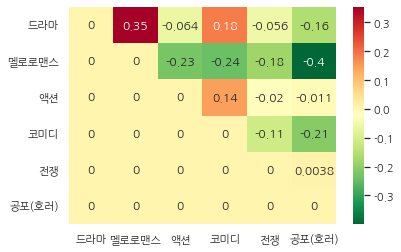

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

In [ ]:
# case : attributes 5개씩

In [92]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [93]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in new_attributes[i]])
        B = np.array([model.wv[word] for word in new_attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [94]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])
    print()

드라마 멜로로맨스 0.42370632
드라마 액션 -0.012376657
드라마 코미디 0.17081377
드라마 전쟁 -0.032317773
드라마 공포(호러) 0.10448189

멜로로맨스 액션 -0.23461801
멜로로맨스 코미디 -0.20954928
멜로로맨스 전쟁 -0.21582234
멜로로맨스 공포(호러) -0.36074692

액션 코미디 0.14734659
액션 전쟁 -0.053029425
액션 공포(호러) 0.06304222

코미디 전쟁 -0.1653758
코미디 공포(호러) -0.10844887

전쟁 공포(호러) 0.07075814



<AxesSubplot:>

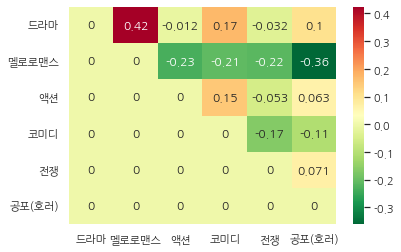

In [95]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

### 루브릭


1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.	
  * 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.	
  * 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.	
  * 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

### 회고

**배운점**  
 - WEAT SCORE를 통해 임베딩 편향성을 측정하는 방법을 배웠다.  
 
**아쉬운점**  
 - 편향성을 알아서 뭐하지? 활용성에 대해 공감이 안간다.  
 - Target을 아트, 일반이 아니라 멜로로맨스와 전쟁or공포 같은 식으로 잡으면 좀 더 경향성이 뚜렷하게 보였을 것 같다.   
   
**느낀 점**    
 - 다음부터는 오래걸리는 결과는 항상 파일로 저장하고 코드를 짤때, if 파일이 없으면 : [ 오래걸리는 코드 ], else : 파일 불러오기 형태로 코드를 작성해야겠다.  
   
**어려웠던 점**   
 - TF-IDF, WEAT SCORE 등 그냥 쓰긴 했는데 개념적으로 잘 모르는 것 같아 다시 한번 공부해야겠다.  